In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as tf
from torchvision import datasets, models
from PIL import Image
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import tarfile
import os
from timeit import default_timer as timer
from typing import Tuple, List, Type, Dict, Any

In [2]:
import zipfile

In [3]:
from itertools import zip_longest

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [5]:
torch.cuda.empty_cache()

In [6]:
!wget -P /content/gdrive/My\ Drive https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0

--2021-12-20 18:49:08--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6024:18::a27d:4412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2021-12-20 18:49:09--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62097e8eb044e5c3ae3ca3f346.dl.dropboxusercontent.com/cd/0/inline/BcMGmND1y57OPKNsAKp7SnrCiaIZ-ypKmvyq5BDgIjSsDCjRC4nTxYEO0h_Gik5xVEqRVxrAwi9ZD0kqCnsL8ZKSzuABM3VKKbXvsPO4wlUFQkTD30apBY5ZQdg3Hm3FY5fCAEbyZZOm6mwV6HEZzJdq/file# [following]
--2021-12-20 18:49:09--  https://uc62097e8eb044e5c3ae3ca3f346.dl.dropboxusercontent.com/cd/0/inline/BcMGmND1y57OPKNsAKp7SnrCiaIZ-ypKmvyq5BDgIjSsDCjRC4nTxYEO0h_Gik5xVEqRVxrAwi9ZD0kqCnsL8ZKSzuABM3

In [7]:
path = "/content/gdrive/My Drive/data.zip?dl=0"
zip_ = zipfile.ZipFile(path)
zip_.extractall(r"/content/gdrive/My Drive/")
zip_.close()

In [8]:
transforms = tf.Compose([tf.ToTensor(),
                         tf.Resize((256, 256)),
    ])

In [9]:
train_dataset = datasets.ImageFolder('/content/gdrive/My Drive/data/train', transform=transforms)

In [10]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [5733, 1433])

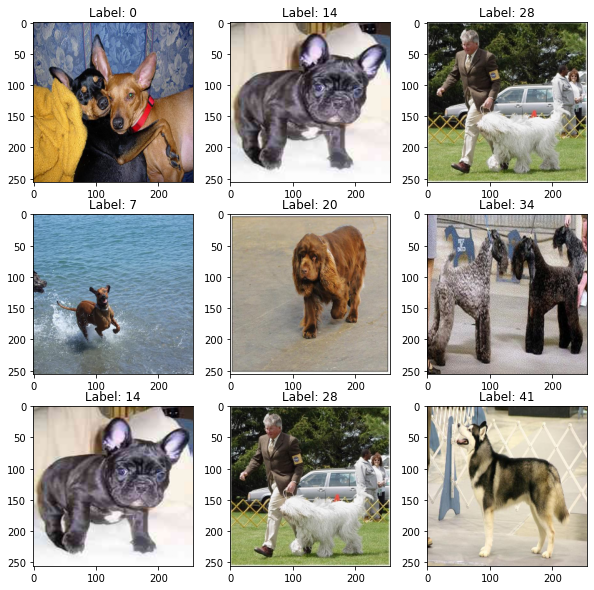

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample, label = train_dataset[i*1000+j*2000]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title('Label: {}'.format(int(label)))

In [12]:
class_to_index = train_dataset.class_to_idx

In [13]:
index_to_class = dict(zip_longest(range(len(class_to_index)), class_to_index.keys()))

In [14]:
def train_single_epoch(model : torch.nn.Module,
                       optimizer : torch.optim.Optimizer,
                       loss_function : torch.nn.Module,
                       data_loader : torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    batches = 0
    for data in data_loader:
        batches += 1
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / batches
    
    return loss_avg

In [15]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    batches = 0
    
    for data in data_loader:
        batches += 1
        X, y = data
        X, y = X.to(device), y.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        
        y_pred = output.argmax(dim = 1, keepdim = True).to(device)
        accuracy_total += (y_pred == y.view_as(y_pred)).cpu().numpy().mean()
        
    loss_avg = loss_total / batches
    accuracy_avg = 100.0 * accuracy_total / batches
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}

In [16]:
def plot_learning_curves(loss_list, accuracy_list, best_epoch):
    """
    Plot loss evolution on training and dev sets and
    accuracy evolution on dev set
    """
    
    # Plot learning loss curve
    plt.plot(loss_list['train'], label = 'Training set')
    plt.plot(loss_list['valid'], label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot accuracy curve         
    plt.plot(accuracy_list, color = 'g', label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Accuracy evolution on validation set')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [70]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20, 
                best_model_root = './best_model.pth'):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory = True, num_workers = 1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers = 1)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'-----Best model yet, saving-----')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, best_model_root)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return
    plot_learning_curves(loss_list, accuracy_list, best_epoch)

In [71]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU', f'({torch.cuda.get_device_name()})')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU (Tesla K80)


In [72]:
model = models.resnext50_32x4d(pretrained=True)


for param in model.parameters():
    param.requires_grad = False
    
  
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
            torch.nn.Linear(num_ftrs, 50)
        )

In [73]:
model.to(device)

print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

Epoch 0
time: 96.6872813839982
Validation metrics: 
{'loss': tensor(0.9540, device='cuda:0'), 'accuracy': 88.45145697167756}
-----Best model yet, saving-----
Epoch 1
time: 96.30318082800295
Validation metrics: 
{'loss': tensor(0.3828, device='cuda:0'), 'accuracy': 94.1606243191721}
-----Best model yet, saving-----
Epoch 2
time: 95.49767985400103
Validation metrics: 
{'loss': tensor(0.2925, device='cuda:0'), 'accuracy': 94.11679602396515}
-----Best model yet, saving-----
Epoch 3
time: 96.13921987299909
Validation metrics: 
{'loss': tensor(0.2425, device='cuda:0'), 'accuracy': 95.15973924291939}
-----Best model yet, saving-----
Epoch 4
time: 95.50557992299946
Validation metrics: 
{'loss': tensor(0.2270, device='cuda:0'), 'accuracy': 94.24700435729848}
-----Best model yet, saving-----
Epoch 5
time: 96.03341985499719
Validation metrics: 
{'loss': tensor(0.2056, device='cuda:0'), 'accuracy': 94.85421772875817}
-----Best model yet, saving-----
Epoch 6
time: 95.6657223459988
Validation metric

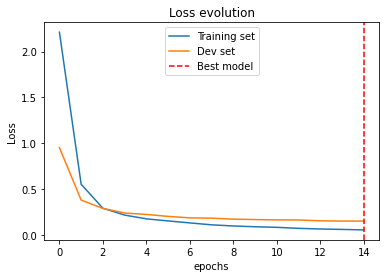

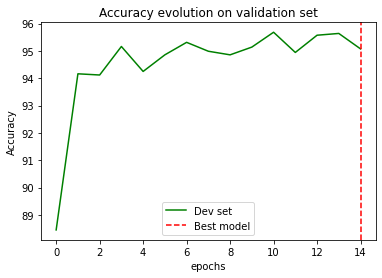

In [74]:
train_model(model, 
            train_dataset=train_set, 
            valid_dataset=val_set, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.001, max_epochs = 15, batch_size = 256)

In [75]:
best_model = torch.load('./best_model.pth')
best_model = best_model.to(device)

In [76]:
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [77]:
import os

filenames = []
for root, dirs, files in os.walk("/content/gdrive/My Drive/data/test"):  
    for filename in files:
        filenames.append(filename)



In [78]:
path = '/content/gdrive/My Drive/data/test'
images = []
labels = []
for filename in filenames:
    image_path = path + '/' + filename
    img = plt.imread(image_path)
    images.append(img)
    labels.append(filename)

In [79]:
class TestDataSet(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        obj = self.data[index]
        if self.transform is not None:
            obj = self.transform(obj)
            
        return obj

In [80]:
test_set = TestDataSet(images, transform=transforms)

In [81]:
predictions = []
for i in range(len(images)):
    y_pred = best_model(test_set[i][None, ...].to(device)).cpu()
    predictions.append(np.argmax(y_pred.detach().numpy()))

In [82]:
true_preds = [index_to_class[i] for i in predictions]

In [83]:
import csv

In [84]:
submit = dict(zip_longest(labels, true_preds))

In [85]:
a_file = open("submit.csv", "w")
writer = csv.writer(a_file)
for key, value in submit.items():
    writer.writerow([key, value])

a_file.close()

# Отчет

So, on the best model I got an accuracy of 96%. At the beginning of my experiments, I took the pretrained ResNet18. 
But got an accuracy of only 85%. Then I looked at which models showed themselves well on imagenet in recent years and took resnext50_32x4d. At this stage, the accuracy has become 96%. Of the augmentations, I tried horizontal and vertical flips, but they only worsened the result. I would like to try something else but time is short and models take a long time to learn. Overall, I am happy with the result.